### In this code we changed N_cav to 20 and N_snap to 10 for faster runtime

In [9]:
# ruff: noqa
import sys, os
sys.path.append(os.path.abspath("./../feedback-grape"))
sys.path.append(os.path.abspath("./../"))

# ruff: noqa
from feedback_grape.fgrape import optimize_pulse, Decay, Gate, evaluate_on_longer_time
from feedback_grape.utils.operators import cosm, sinm, identity
from feedback_grape.utils.states import coherent
import jax.numpy as jnp
import jax
from feedback_grape.utils.operators import create, destroy
from feedback_grape.utils.fidelity import ket2dm
from library.utils.FgResult_to_dict import FgResult_to_dict
from tqdm import tqdm
import json

jax.config.update("jax_enable_x64", True)

In [10]:
# Training parameters
N_training_iterations = 1000 # Number of training iterations
learning_rate = 0.01 # Learning rate
convergence_threshold = 1e-6 # Convergence threshold for early stopping
N_samples = 5 # Number of random initializations to try
N_eval_time_steps = 1000 # Number of time steps for evaluation on longer time

num_time_steps = 3
lut_depth = 2
reward_weights = [1, 1, 1]

# Physical parameters
N_cav = 10  # number of cavity modes
N_snap = 5

alpha = 2
psi_target = coherent(N_cav, alpha) + coherent(N_cav, -alpha)

# Normalize psi_target before constructing rho_target
psi_target = psi_target / jnp.linalg.norm(psi_target)

rho_target = ket2dm(psi_target)

for w in reward_weights:
    assert type(w) == int and 0 <= w <= 9, "Weights must be integers between 0 and 9 to save as single character in filename."

In [11]:
def displacement_gate(alphas):
    """Displacement operator for a coherent state."""
    alpha_re, alpha_im = alphas
    alpha = alpha_re + 1j * alpha_im
    gate = jax.scipy.linalg.expm(
        alpha * create(N_cav) - alpha.conj() * destroy(N_cav)
    )
    return gate

def initialize_displacement_gate(key):
    return Gate(
        gate=displacement_gate,
        initial_params=jax.random.uniform(
            key,
            shape=(2,),
            minval=-jnp.pi / 2,
            maxval=jnp.pi / 2,
            dtype=jnp.float64,
        ),
        measurement_flag=False,
    )

def displacement_gate_dag(alphas):
    """Displacement operator for a coherent state."""
    return displacement_gate(alphas).conj().T

def initialize_displacement_gate_dag(key):
    return Gate(
        gate=displacement_gate_dag,
        initial_params=jax.random.uniform(
            key,
            shape=(2,),
            minval=-jnp.pi / 2,
            maxval=jnp.pi / 2,
            dtype=jnp.float64,
        ),
        measurement_flag=False,
    )

def snap_gate(phase_list):
    diags = jnp.ones(shape=(N_cav - len(phase_list)))
    exponentiated = jnp.exp(1j * jnp.array(phase_list))
    diags = jnp.concatenate((exponentiated, diags))
    return jnp.diag(diags)

def initialize_snap_gate(key):
    return Gate(
        gate=snap_gate,
        initial_params=jax.random.uniform(
            key,
            shape=(N_snap,),
            minval=-jnp.pi / 2,
            maxval=jnp.pi / 2,
            dtype=jnp.float64,
        ),
        measurement_flag=False,
    )

def povm_measure_operator(measurement_outcome, params):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    gamma, delta = params
    cav_operator = gamma * create(N_cav) @ destroy(N_cav) + delta * identity(N_cav) / 2
    angle = cav_operator
    meas_op = jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )
    return meas_op

def initialize_povm_gate(key):
    return Gate(
        gate=povm_measure_operator,
        initial_params=jax.random.uniform(
            key,
            shape=(2,),  # 2 for gamma and delta
            minval=-jnp.pi / 2,
            maxval=jnp.pi / 2,
            dtype=jnp.float64,
        ),
        measurement_flag=True,
    )

decay_gate = Decay(c_ops=[jnp.sqrt(0.005) * destroy(N_cav)])

def initialize_system_params(key):
    keys = jax.random.split(key, 4)
    return [
        decay_gate,
        initialize_povm_gate(keys[0]),
        decay_gate,
        initialize_displacement_gate(keys[1]),
        initialize_snap_gate(keys[2]),
        initialize_displacement_gate_dag(keys[3])
    ]

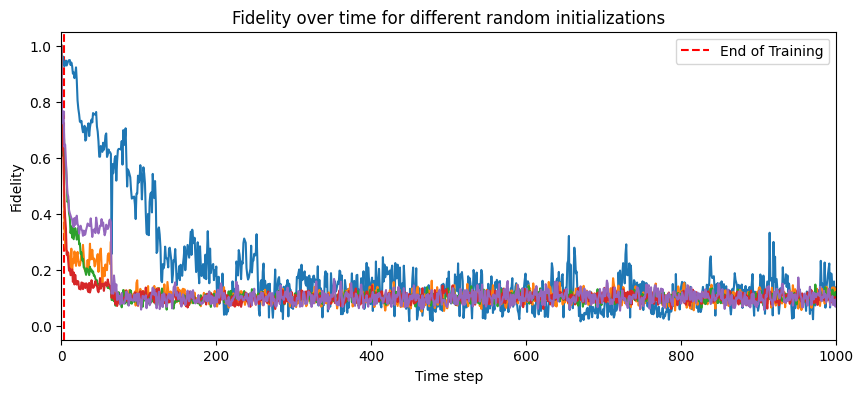

100%|██████████| 5/5 [53:12<00:00, 638.50s/it]


In [12]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.set_xlabel("Time step")
ax.set_ylabel("Fidelity")
ax.set_title("Fidelity over time for different random initializations")
ax.axvline(x=num_time_steps, color='r', linestyle='--', label='End of Training')
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(0, N_eval_time_steps)
ax.legend()

for s in tqdm(range(N_samples)):
    system_params = initialize_system_params(jax.random.PRNGKey(s))

    result = optimize_pulse(
        U_0=rho_target,
        C_target=rho_target,
        system_params=system_params,
        num_time_steps=num_time_steps,
        lut_depth=lut_depth,
        reward_weights=reward_weights,
        mode="lookup",
        goal="fidelity",
        max_iter=N_training_iterations,
        convergence_threshold=convergence_threshold,
        learning_rate=learning_rate,
        evo_type="density",
        batch_size=16,
        progress=False,
    )

    print(f"Run s={s}, Iterations: {result.iterations}")

    eval_result = evaluate_on_longer_time(
        U_0 = rho_target,
        C_target = rho_target,
        system_params = system_params,
        optimized_trainable_parameters = result.optimized_trainable_parameters,
        num_time_steps = N_eval_time_steps,
        evo_type = "density",
        goal = "fidelity",
        eval_batch_size = 16, # Default is 10
        mode = "lookup",
        rnn = None,
        rnn_hidden_size = None,
    )

    ax.plot(eval_result.fidelity_each_timestep, label=f"Run s={s}")

    # Update plot
    clear_output(wait=True)
    display(fig)
    plt.pause(0.1)

plt.ioff()
plt.show()